## Spatial Autocorrelation in Inglewood 

In [2]:
# Pandas helps us read and wrange the data we need.
import pandas as pd

# I am using Sodaypy Socrata to import the data from the Assessors Data Portal 
from sodapy import Socrata

# To Create a Spatial Design I will use Geopandas
import geopandas as gpd

# I will import Contextily for basemaps
import contextily as ctx

# For Spatial Statistics - ESDA will help us MATH 
import esda
from esda.moran import Moran, Moran_Local

# This library - SPLOT, will help us splot stuff?
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

# Not sure what this does yet, but i'll find out as I review the LAB!
import libpysal as lps

# Graphics, well you know - GRapHIcs!?

import matplotlib.pyplot as plt
import plotly.express as px


# https://data.lacounty.gov/resource/9trm-uz8i.json
# https://api.census.gov/data.json




# Using Block Groups instead of Census Tracts

Ok - we are using the census data for 2019 solely for census block group shapes. We still need to find a way for it to help us tell our story.


Data Source:Census Bureau: "Census Reporter: ACS 2019 5 year: Table B01003".

In [3]:
# These are our tracts... 
gdf = gpd.read_file('Data/acs2019_5yr_B01003_15000US060376007041.geojson')

In [4]:
#this is what our data looks like... 
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             76 non-null     object  
 1   name              76 non-null     object  
 2   B01003001         76 non-null     float64 
 3   B01003001, Error  76 non-null     float64 
 4   geometry          76 non-null     geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 3.1+ KB


In [5]:
# we are going to trim to only focus on a few columns. 


gdf = gdf[['geoid','B01003001','geometry']]

# Now we want to rename our columns. 

gdf.columns = ['FIPS','TotalPop','geometry']

In [6]:
# Last row command to find the total population row, which we dont need.
gdf.tail()

,FIPS,TotalPop,geometry
71,15000US060376020041,2229.0,"MULTIPOLYGON (((-118.33514 33.93102, -118.3351..."
72,15000US060376020042,1480.0,"MULTIPOLYGON (((-118.33039 33.93677, -118.3303..."
73,15000US060376021041,3385.0,"MULTIPOLYGON (((-118.34831 33.93192, -118.3482..."
74,15000US060377030023,2619.0,"MULTIPOLYGON (((-118.38655 33.97716, -118.3862..."
75,16000US0636546,109613.0,"MULTIPOLYGON (((-118.37625 33.98285, -118.3762..."


In [ ]:
# delete last row which is for the entire city of Inglewood (dropping it)
gdf=gdf.drop(75)

In [10]:
# last rows
gdf.tail()

# its gone!

,FIPS,TotalPop,geometry
70,15000US060376020032,2332.0,"MULTIPOLYGON (((-118.33935 33.93484, -118.3393..."
71,15000US060376020041,2229.0,"MULTIPOLYGON (((-118.33514 33.93102, -118.3351..."
72,15000US060376020042,1480.0,"MULTIPOLYGON (((-118.33039 33.93677, -118.3303..."
73,15000US060376021041,3385.0,"MULTIPOLYGON (((-118.34831 33.93192, -118.3482..."
74,15000US060377030023,2619.0,"MULTIPOLYGON (((-118.38655 33.97716, -118.3862..."


In [11]:
# fix FIPS code: getting rid of all the crazy numbers ahead of what we really care about. 
gdf['FIPS'] = gdf['FIPS'].str.replace('15000US','')
gdf.tail()


,FIPS,TotalPop,geometry
70,060376020032,2332.0,"MULTIPOLYGON (((-118.33935 33.93484, -118.3393..."
71,060376020041,2229.0,"MULTIPOLYGON (((-118.33514 33.93102, -118.3351..."
72,060376020042,1480.0,"MULTIPOLYGON (((-118.33039 33.93677, -118.3303..."
73,060376021041,3385.0,"MULTIPOLYGON (((-118.34831 33.93192, -118.3482..."
74,060377030023,2619.0,"MULTIPOLYGON (((-118.38655 33.97716, -118.3862..."


In [12]:
# Now we sort our data by the total population in each block "
gdf.sort_values(by='TotalPop').head(20)

,FIPS,TotalPop,geometry
47,060376013021,424.0,"MULTIPOLYGON (((-118.36879 33.96817, -118.3687..."
16,060376008013,465.0,"MULTIPOLYGON (((-118.32662 33.96180, -118.3265..."
14,060376008011,549.0,"MULTIPOLYGON (((-118.32208 33.96640, -118.3220..."
6,060376006013,622.0,"MULTIPOLYGON (((-118.32283 33.94185, -118.3220..."
19,060376008022,637.0,"MULTIPOLYGON (((-118.33471 33.96318, -118.3347..."
15,060376008012,649.0,"MULTIPOLYGON (((-118.32270 33.96370, -118.3226..."
59,060376014023,736.0,"MULTIPOLYGON (((-118.37006 33.95266, -118.3700..."
45,060376013011,743.0,"MULTIPOLYGON (((-118.37034 33.98164, -118.3701..."
4,060376006011,793.0,"MULTIPOLYGON (((-118.32641 33.94279, -118.3264..."
8,060376007021,903.0,"MULTIPOLYGON (((-118.32210 33.95273, -118.3209..."


In [13]:
#the largest block is number 61!

In [14]:
# We want to get rid of blocks with less than 100 population geographies ... but i dont think any of them have that issue here.
gdf = gdf[gdf['TotalPop']>100]


## Map the census block groups

In [15]:

#Now we get our layer into a web mercator projection and reproject it
gdf = gdf.to_crs(epsg=3857)

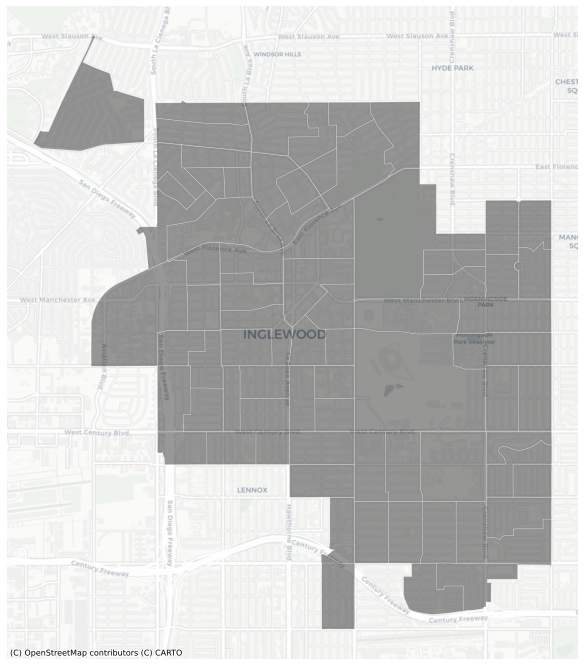

In [16]:
# This is a plot of our blocks... which threw me off because the last time I did it during week 2... the method was a lot smoother it would seem.
fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Get Parcel Data from LA Assessors Data Portal
Now we call for our the data using the socrata API. I will be looking solely at the years between 2000 and 2010.

In [18]:
client = Socrata("data.lacounty.gov", None)

results = client.get("9trm-uz8i",
                    limit=50000,
                    where="taxratearea_city='INGLEWOOD' AND rollyear=2010 AND yearbuilt between 2000 and 2010")

df = pd.DataFrame.from_records(results)

In [20]:
#Ok lets see what we have so far...

In [19]:
df.sample(1)

,situszip,taxratearea_city,ain,rollyear,taxratearea,assessorid,propertylocation,usetype,usecode,usecodedescchar1,...,situsfraction,situsdirection,situsstreet,situsunit,situscity,situszip5,rowid,center_lat,center_lon,location_1
210,90305-1999,INGLEWOOD,4025023031,2010,04596,4025-023-031,3542 W CHAUCER LN INGLEWOOD CA 90305,SFR,0100,Residential,...,,W,CHAUCER LN,,INGLEWOOD CA,90305,20104025023031,33.95345338,-118.33183742,"{'latitude': '33.95345338', 'longitude': '-118..."


In [21]:
#This is what our data looks like... nice - not too large... is this a good thing or a bad thing?

In [22]:
df.shape

(576, 51)

In [24]:
#Going from Data Frame (df) to GeoDataFrame (gdf) for mapping purposes. 

In [27]:
#Pull data

In [25]:
df = gpd.GeoDataFrame(df, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(df.center_lon, df.center_lat))

In [28]:
#Project it on to the base map. 

In [29]:
df = df.to_crs(epsg=3857)

In [30]:
#Redefine our long/lat data for plotting purposes

In [31]:
df.center_lon = df.center_lon.astype('float')
df.center_lat = df.center_lat.astype('float')

In [32]:
#Lets see what we got

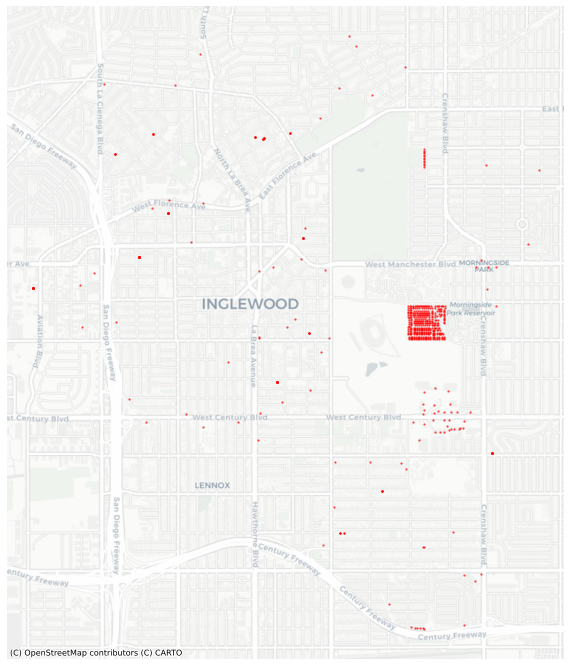

In [33]:
fig,ax = plt.subplots(figsize=(12,12))

df.plot(ax=ax,
             color='red',
             markersize=2, alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [34]:
#This is what we have for buildings built between 2000 and 2010!

In [35]:
# get the bounding box coordinates for the data
minx, miny, maxx, maxy = df.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13177775.485143559
-13171351.199481253
4018790.0200208784
4026315.488119194


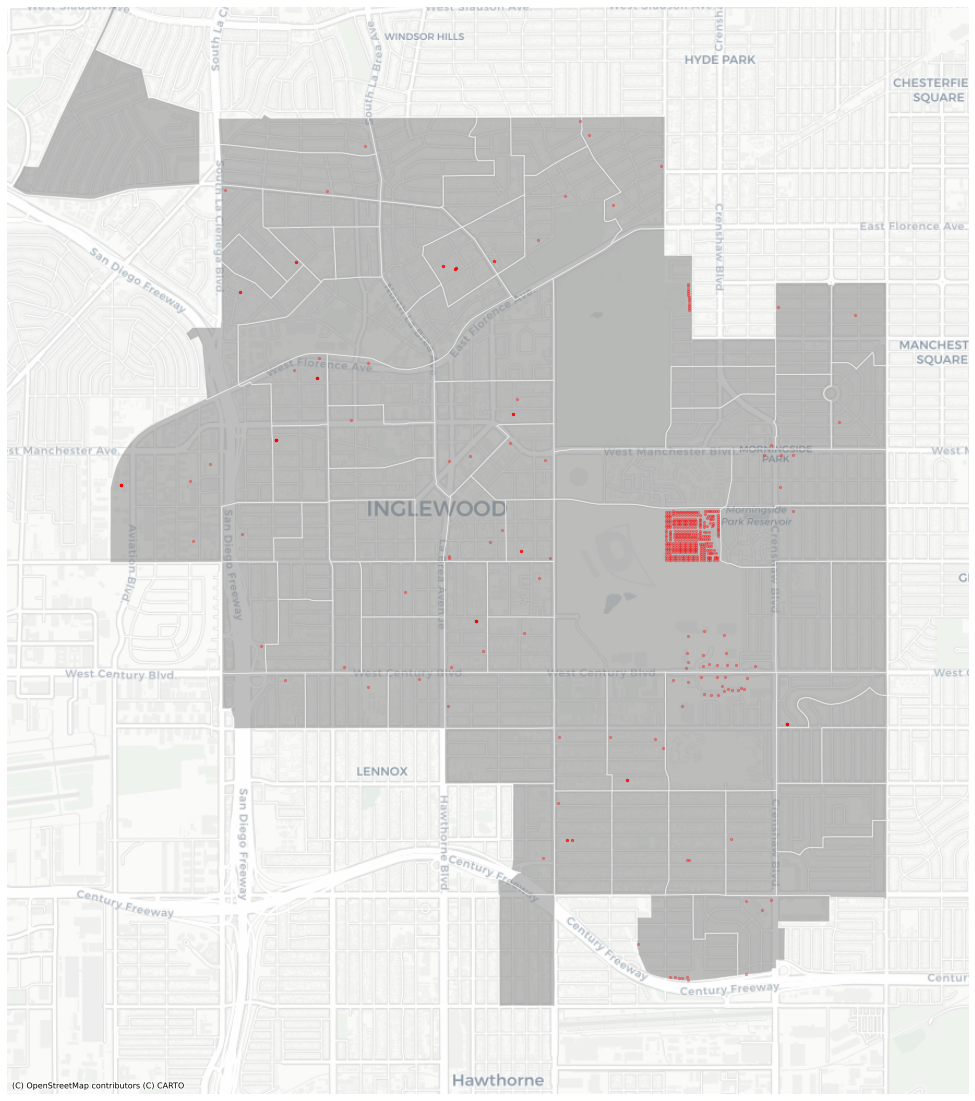

In [36]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(20, 20))

# block groups
gdf.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.5)

# properties built in Inglewood between 1950-2020
df.plot(ax=ax, # this also puts it in the same ax plot
            color='red',
            markersize=5,
            alpha=0.3)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [38]:
#We can now beging to analyze using the census blocks! 
#We can easily see now which census block has had the most construction... but now we need to figure out more details.

# The rest of this NB is just playing with the Join so we can try to add layers of depth in our analysis.... but its a work in progress that we got lost in.

In [39]:
join = gpd.sjoin(df, gdf, how='left')
join.head()

,situszip,taxratearea_city,ain,rollyear,taxratearea,assessorid,propertylocation,usetype,usecode,usecodedescchar1,...,situscity,situszip5,rowid,center_lat,center_lon,location_1,geometry,index_right,FIPS,TotalPop
0,90302-1140,INGLEWOOD,4002015038,2010,04569,4002-015-038,1300 CENTINELA AVE INGLEWOOD CA 90302,C/I,1100,Commercial,...,INGLEWOOD CA,90302,20104002015038,33.976890,-118.361746,"{'latitude': '33.97689024', 'longitude': '-118...",POINT (-13175969.323 4025699.372),46,060376013012,1178.0
1,90302-1224,INGLEWOOD,4002020007,2010,04569,4002-020-007,114 W 64TH PL INGLEWOOD CA 90302,R-I,0500,Residential,...,INGLEWOOD CA,90302,20104002020007,33.979821,-118.358830,"{'latitude': '33.97982101', 'longitude': '-118...",POINT (-13175644.650 4026092.803),45,060376013011,743.0
2,90305-1021,INGLEWOOD,4009021013,2010,04569,4009-021-013,3029 W 78TH ST INGLEWOOD CA 90305,SFR,0100,Residential,...,INGLEWOOD CA,90305,20104009021013,33.969333,-118.326292,"{'latitude': '33.96933255', 'longitude': '-118...",POINT (-13172022.534 4024684.880),17,060376008014,1536.0
3,90305-1120,INGLEWOOD,4009026002,2010,04569,4009-026-002,2406 W 78TH ST INGLEWOOD CA 90305,SFR,0100,Residential,...,INGLEWOOD CA,90305,20104009026002,33.968815,-118.320261,"{'latitude': '33.96881495', 'longitude': '-118...",POINT (-13171351.199 4024615.404),14,060376008011,549.0
4,90305-1805,INGLEWOOD,4010032006,2010,04569,4010-032-006,2611 W 84TH PL INGLEWOOD CA 90305,SFR,0100,Residential,...,INGLEWOOD CA,90305,20104010032006,33.961812,-118.321481,"{'latitude': '33.96181235', 'longitude': '-118...",POINT (-13171486.988 4023675.510),15,060376008012,649.0


In [40]:
join.sample(1)

,situszip,taxratearea_city,ain,rollyear,taxratearea,assessorid,propertylocation,usetype,usecode,usecodedescchar1,...,situscity,situszip5,rowid,center_lat,center_lon,location_1,geometry,index_right,FIPS,TotalPop
241,90305-1882,INGLEWOOD,4025021040,2010,04596,4025-021-040,3651 W MEDICI LN INGLEWOOD CA 90305,SFR,0100,Residential,...,INGLEWOOD CA,90305,20104025021040,33.953304,-118.334311,"{'latitude': '33.9533043', 'longitude': '-118....",POINT (-13172915.245 4022533.657),10,060376007023,2398.0


In [41]:
join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 576 entries, 0 to 575
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   situszip                   576 non-null    object  
 1   taxratearea_city           576 non-null    object  
 2   ain                        576 non-null    object  
 3   rollyear                   576 non-null    object  
 4   taxratearea                576 non-null    object  
 5   assessorid                 576 non-null    object  
 6   propertylocation           567 non-null    object  
 7   usetype                    576 non-null    object  
 8   usecode                    576 non-null    object  
 9   usecodedescchar1           576 non-null    object  
 10  usecodedescchar2           576 non-null    object  
 11  usecodedescchar3           576 non-null    object  
 12  usecodedescchar4           576 non-null    object  
 13  totbuildingdatalines       

In [42]:
properties_built_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='total_properties_built')
properties_built_by_gdf.head(20)

,FIPS,total_properties_built
0,060376007023,389
1,060376006021,17
2,060376014013,14
3,060376008021,13
4,060376009022,12
5,060376011002,12
6,060376014012,12
7,060376014011,10
8,060376006011,8
9,060376010012,8


In [43]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      75 non-null     object  
 1   TotalPop  75 non-null     float64 
 2   geometry  75 non-null     geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 2.3+ KB


In [44]:
gdf = gdf[['FIPS',
           'TotalPop',
           'geometry']]

In [45]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      75 non-null     object  
 1   TotalPop  75 non-null     float64 
 2   geometry  75 non-null     geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 2.3+ KB


In [46]:
properties_built_by_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   FIPS                    47 non-null     object
 1   total_properties_built  47 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 880.0+ bytes


In [47]:
properties_built_by_gdf.head()

,FIPS,total_properties_built
0,060376007023,389
1,060376006021,17
2,060376014013,14
3,060376008021,13
4,060376009022,12


<AxesSubplot:xlabel='FIPS'>

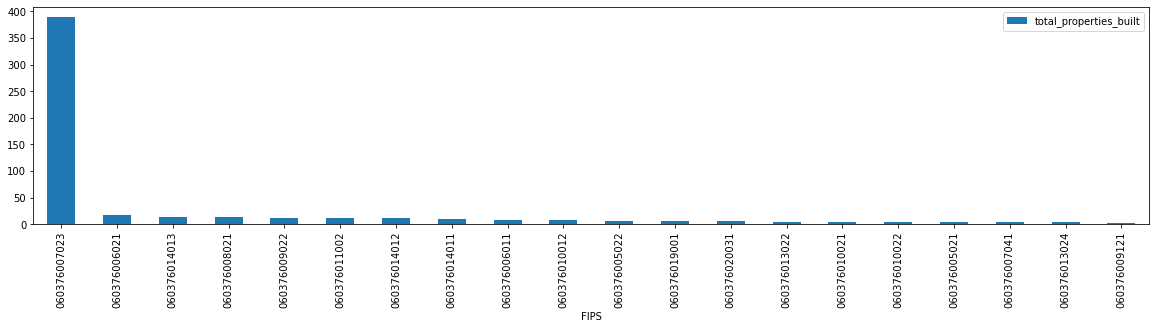

In [48]:
properties_built_by_gdf[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='total_properties_built')

In [49]:
gdf=gdf.merge(properties_built_by_gdf,on='FIPS')

In [50]:
gdf.head()

,FIPS,TotalPop,geometry,total_properties_built
0,060376005021,1113.0,"MULTIPOLYGON (((-13172766.298 4019470.333, -13...",4
1,060376005022,984.0,"MULTIPOLYGON (((-13173255.659 4019132.509, -13...",7
2,060376006011,793.0,"MULTIPOLYGON (((-13172035.820 4021123.242, -13...",8
3,060376006021,2542.0,"MULTIPOLYGON (((-13173009.977 4020884.797, -13...",17
4,060376007023,2398.0,"MULTIPOLYGON (((-13173985.803 4022454.303, -13...",389


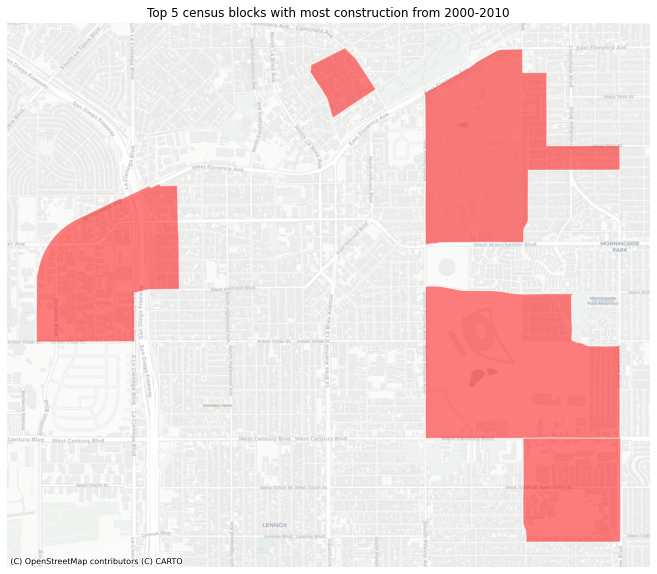

In [52]:
# map the top 20 census blocks that have experienced the most construction from 1950-2010
fig,ax = plt.subplots(figsize=(12,10))
gdf.sort_values(by='total_properties_built',ascending=False)[:5].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 5 census blocks with most construction from 2000-2010')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)